# Exploring NYC's CitiBike data

#### November 2015
The article/blog post about this analysis can be found [here](http://luisvalesilva.github.io/datasimple/citibike.html).

## Table of Contents
* [Introduction](#Introduction)
* [Methods](#Methods)
* [Getting the data](#Getting_the_data)
* [Analysis](#Analysis)
    1. [Temporal patterns of citibike use](#Temporal_patterns)
    2. [Map trip count and duration according to start station](#Map_start)
    3. [Map trip count and duration according to end station](#Map_end)
    4. [Hourly changes in start station (video)](#Gif_start)

<a id='Introduction'></a>
## Introduction

CitiBike's data sharing information can be found at their [System Data website](https://www.citibikenyc.com/system-data). They provide information about the data set, such as included variables and their description. The data have been pre-cleaned before uploading, for example by removing trips taken by staff and any trips below 60 seconds in length. This means the data should be ready to use with no need for additional cleaning.

The data are organized in monthly subsets (each in its own '.csv' file) and are available since July 2013, soon after citibike service started, up until October 2015 (previous month, as of this writing). Using data from one whole year is probably the most appropriate, as there may be yearly patterns. Also, this will provide a good amount of observations, enough for most analysis we may want to do. For this exercise I will thus use all 2014 data, as this is the only full year available so far.

The data are hosted on and can be downloaded from Amazon Simple Storage Service (Amazon S3).

<a id='Methods'></a>
## Methods

This data analysis was made on a MacBook Pro laptop. Besides the shell (Bash), I used the following tools in [Python](https://www.python.org/):

* [Pandas](http://pandas.pydata.org/) for data manipulation.
* [Folium](http://folium.readthedocs.org/en/latest/) for mapping.

To generate the video of the dynamic visualization of citibike station use accross the different hours of the day I used Apple's iMovie.

<a id='Getting_the_data'></a>
## Getting the data

I will use the shell (bash in this case) to get the data. Download the files using `curl` and then unzip them and remove the zipped versions.

In [13]:
# Add `!` preceding the command to run shell commands
# Curl accepts ranges
!curl -O "https://s3.amazonaws.com/tripdata/2014[01-12]-citibike-tripdata.zip"
!unzip '*.zip'
!rm *.zip


[1/12]: https://s3.amazonaws.com/tripdata/201401-citibike-tripdata.zip --> 201401-citibike-tripdata.zip
--_curl_--https://s3.amazonaws.com/tripdata/201401-citibike-tripdata.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9470k  100 9470k    0     0  20.1M      0 --:--:-- --:--:-- --:--:-- 20.2M

[2/12]: https://s3.amazonaws.com/tripdata/201402-citibike-tripdata.zip --> 201402-citibike-tripdata.zip
--_curl_--https://s3.amazonaws.com/tripdata/201402-citibike-tripdata.zip
100 7076k  100 7076k    0     0  41.3M      0 --:--:-- --:--:-- --:--:-- 41.3M

[3/12]: https://s3.amazonaws.com/tripdata/201403-citibike-tripdata.zip --> 201403-citibike-tripdata.zip
--_curl_--https://s3.amazonaws.com/tripdata/201403-citibike-tripdata.zip
100 13.4M  100 13.4M    0     0  61.8M      0 --:--:-- --:--:-- --:--:-- 61.8M

[4/12]: https://s3.amazonaws.com/tripdata/201404-citibike-tripdata.zip

The next step is to load the data with Pandas. I will use a `for loop` to read all 12 csv files into a list of Pandas *DataFrames*.

In [14]:
# Get file names
import glob
filenames = glob.glob('*.csv')

In [15]:
import pandas as pd
# Loop through file names and read the data
dfs = []
for file in filenames:
    print('Reading ' + file)
    dfs.append(pd.read_csv(file))

Reading 2014-01 - Citi Bike trip data.csv
Reading 2014-02 - Citi Bike trip data.csv
Reading 2014-03 - Citi Bike trip data.csv
Reading 2014-04 - Citi Bike trip data.csv
Reading 2014-05 - Citi Bike trip data.csv
Reading 2014-06 - Citi Bike trip data.csv
Reading 2014-07 - Citi Bike trip data.csv
Reading 2014-08 - Citi Bike trip data.csv
Reading 201409-citibike-tripdata.csv
Reading 201410-citibike-tripdata.csv
Reading 201411-citibike-tripdata.csv
Reading 201412-citibike-tripdata.csv


In [16]:
# Remove .csv files as we no longer need them
!rm *.csv

The file naming structure changes from September on. Hopefully, that's all that changes between the data sets. This is not a good sign, though, as it may indicate other changes in the data. It is definitely worth it to take a more in-depth look.

In [17]:
dfs[7].head(2) # Check August

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1142,2014-08-01 00:00:04,2014-08-01 00:19:06,470,W 20 St & 8 Ave,40.743453,-74.00004,312,Allen St & E Houston St,40.722055,-73.989111,19117,Subscriber,1969,1
1,117,2014-08-01 00:00:05,2014-08-01 00:02:02,236,St Marks Pl & 2 Ave,40.728419,-73.98714,432,E 7 St & Avenue A,40.726218,-73.983799,20549,Subscriber,1991,1


In [21]:
dfs[8].head(2)  # Check September

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,2828,9/1/2014 00:00:25,9/1/2014 00:47:33,386,Centre St & Worth St,40.714948,-74.002345,450,W 49 St & 8 Ave,40.762272,-73.987882,15941,Subscriber,1980,1
1,368,9/1/2014 00:00:28,9/1/2014 00:06:36,387,Centre St & Chambers St,40.712733,-74.004607,2008,Little West St & 1 Pl,40.705693,-74.016777,18962,Subscriber,1982,1


Indeed, there's an important format difference: the `starttime` and `stoptime` variables use different string formats. This will be important later on as we use these timestamps for the analyses.

There are several ways we can fix this. The most convenient way to use time series data is to convert it to the appropriate data type (pandas uses NumPy's `datetime64`). I will use the function `to_datetime` to do this. `to_datetime` is very flexible and will recognize a wide variety of string formats. We can also use the `format` argument to give it information about the format, which can make it faster. In this case, I will use that only from September on, when the format changes. A little `for loop` will help save some typing.

In [22]:
print('Converting month:')
for month in range(12):
    if month < 8:
        print('... ' + str(month + 1))
        dfs[month]['starttime'] = pd.to_datetime(dfs[month]['starttime'])
        dfs[month]['stoptime'] = pd.to_datetime(dfs[month]['stoptime'])
    else:
        print('... ' + str(month + 1))
        dfs[month]['starttime'] = pd.to_datetime(dfs[month]['starttime'],
                                                 format = '%m/%d/%Y %H:%M:%S')
        dfs[month]['stoptime'] = pd.to_datetime(dfs[month]['stoptime'],
                                                format = '%m/%d/%Y %H:%M:%S')

Converting month:
... 1
... 2
... 3
... 4
... 5
... 6
... 7
... 8
... 9
... 10
... 11
... 12


In [14]:
# Confirm that the data type for the two variables is now datetime64
dfs[8].dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [23]:
# Check the format of the time stamps
# (simply looking at the last rows will show an example
# that used to be in the different format - post September)
dfs[8].tail(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
953885,439,2014-09-30 23:59:58,2014-10-01 00:07:17,479,9 Ave & W 45 St,40.760193,-73.991255,519,Pershing Square North,40.751873,-73.977706,15271,Subscriber,1984,1
953886,978,2014-09-30 23:59:59,2014-10-01 00:16:17,147,Greenwich St & Warren St,40.715422,-74.011220,116,W 17 St & 8 Ave,40.741776,-74.001497,15068,Subscriber,1992,1


Now that the timestamps are consistent, I will concatenate the datasets to obtain one dataframe containing all data for 2014.

In [24]:
df = pd.concat(dfs)

In [25]:
df.shape

(8081216, 15)

I now have a pandas `DataFrame` in memory containing all the data combined together in a structured way. I will use the `pickle` module (part of the Python standard library) to save the data in the current format (a concept known as *serialization*). This will write a `.pkl` file to disk that I can save and easily read back to memory at any point in the future as I go on with the analysis (or even share with someone, if needed).

In [26]:
df.to_pickle('../Data/citibike_2014.pkl')

<a id='Analysis'></a>
## Analysis

Get an overview of the data, by looking at the general aspect of the variables, data types, total number of observations, and so on.

In [6]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [7]:
file_name = '../Data/citibike_2014.pkl'
%time df = pd.read_pickle(file_name) # Read data and print elapsed time

CPU times: user 19.9 s, sys: 1.34 s, total: 21.2 s
Wall time: 28.8 s


I will start by taking a look at some of the properties of the data set, such as the overall dimensions, the variables and the format of their data.

In [5]:
# How many observations and variables are there
df.shape

(8081216, 15)

In [4]:
# Variable names and data types
df.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                         object
gender                              int64
dtype: object

In [5]:
df.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1


In [5]:
# Summary of the numerical variables
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,gender
count,8081216.000000,8081216.000000,8081216.000000,8081216.000000,8081216.000000,8081216.000000,8081216.000000,8081216.000000,8081216.000000
mean,851.175207,447.975454,40.734568,-73.991041,446.712358,40.734295,-73.991177,18120.661105,1.105837
std,4488.807328,362.021311,0.019329,0.012176,360.686612,0.019332,0.012243,2081.094092,0.539799
min,60.000000,72.000000,40.680342,-74.017134,72.000000,40.680342,-74.017134,14529.000000,0.000000
25%,390.000000,305.000000,40.721655,-73.999947,305.000000,40.721101,-74.000040,16329.000000,1.000000
50%,616.000000,404.000000,40.736245,-73.990765,404.000000,40.735877,-73.990931,18112.000000,1.000000
75%,1010.000000,489.000000,40.750020,-73.982050,488.000000,40.749156,-73.982050,19897.000000,1.000000
max,5416640.000000,3002.000000,40.771522,-73.950048,3002.000000,40.771522,-73.950048,21690.000000,2.000000


In [10]:
df['bikeid'].unique().shape # Number of individual bikes

(6811,)

In [7]:
df['start station id'].unique().shape # Number of citibike stations

(332,)

One thing I am curious about is user gender distribution.

In [8]:
df['gender'].unique() # from citibike's description of the data: Zero=unknown; 1=male; 2=female.

array([1, 2, 0])

In [5]:
# Prepare data
genders = ['Unknown', 'Male', 'Female']
y_pos = [0, 1, 2]
trip_counts = df.groupby('gender')['gender'].count()

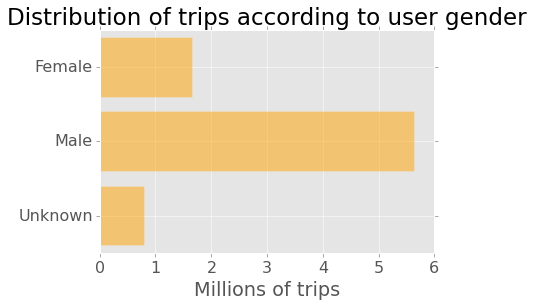

In [6]:
# Plot
plt.rcParams.update({'font.size': 16})
plt.barh(y_pos, trip_counts / 1000000, align = 'center', alpha = 0.5, color = 'orange')
plt.yticks(y_pos, genders)
plt.xlabel('Millions of trips')
plt.title('Distribution of trips according to user gender')
plt.show()

Another interesting point is trip duration. We know from the summary statistics we looked at above that the mean trip duration is 851 seconds (about 14 minutes), with a large standard deviation (4489 sec. or 75 min.). Let's look at the distribution in more detail.

In [3]:
# Collect all trips shorter than 1 hour
duration_mins = df.loc[(df.tripduration / 60 < 60)][['tripduration']]
duration_mins = duration_mins / 60 # In minutes

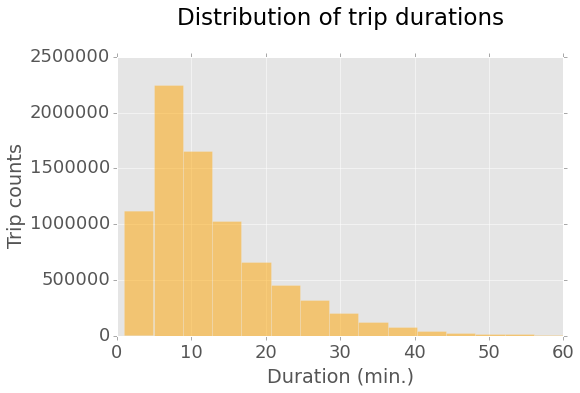

In [7]:
# Plot the distribution of trip durations
plt.rcParams.update({'font.size': 16})
duration_mins.hist(figsize = (8,5), bins = 15, alpha = 0.5, color = 'orange')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Distribution of trip durations\n')
plt.xlabel('Duration (min.)')
plt.ylabel('Trip counts')

The histogram shows that most trips are rather short. As duration increases the number of trips gets smaller and long trips are not very frequent.

There are many interesting questions to explore using these data. In this analysis I will be focusing on comparing the different citibike stations in the network according to number of trips and their duration. The final goal is to build visualizations of total trip counts and trip duration on maps of the citibike station network.

<a id='Temporal_patterns'></a>
## 1. Temporal patterns of citibike use

In [8]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df.loc[:, ['tripduration', 'starttime']] # Keep only 'starttime' and 'tripduration' variables
# Index dataframe by 'datetime64' data in 'starttime' variable
df_sub.index = df_sub['starttime']
weekdays = df_sub[df_sub.index.weekday < 5]
weekends = df_sub[df_sub.index.weekday > 4]
weekdays_countsPerHr = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr = weekends.groupby(weekends.index.hour).size()

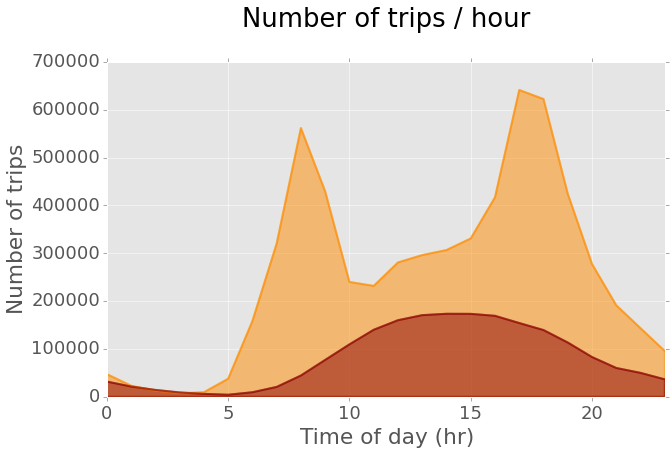

In [11]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr.plot(kind = 'area', stacked = False, figsize = (10, 6), color = 'darkorange',
                          linewidth = 2, label='Weekdays')

weekends_countsPerHr.plot(kind = 'area', stacked = False, color = 'darkred',
                          linewidth = 2, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips / hour\n')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

In [12]:
df.index = df['starttime']
countsPerDay = df.starttime.resample('D', how = ['count'])

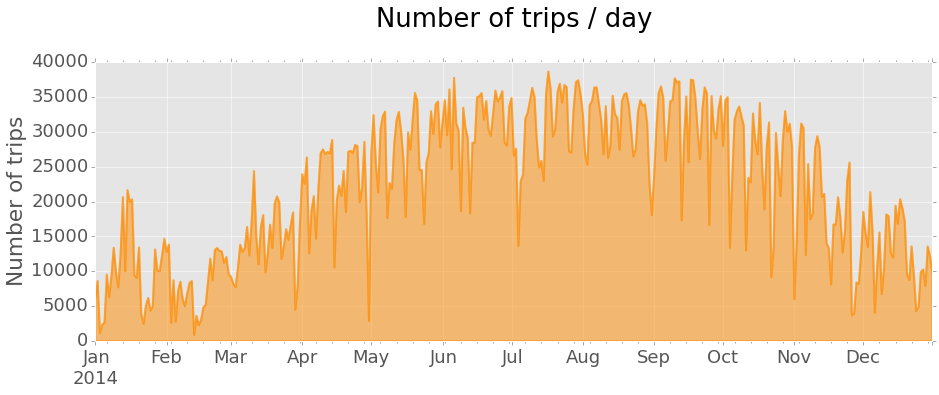

In [13]:
countsPerDay.plot(kind = 'area', stacked = False, figsize = (15, 5),
                  color = 'darkorange', linewidth = 2, legend = False)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips / day\n')
plt.xlabel('')
plt.ylabel('Number of trips')

<a id='Map_start'></a>
## 2. Map trip count and duration according to start station
Get only start station id, name and coordinates, drop duplicates and add columns with trip counts and mean duration for each station.

In [8]:
start_station = df.iloc[:,[3, 4, 5, 6]]
start_station.index = start_station['start station id']
start_station.head()

,start station id,start station name,start station latitude,start station longitude
start station id,,,,
2009,2009,Catherine St & Monroe St,40.711174,-73.996826
536,536,1 Ave & E 30 St,40.741444,-73.975361
228,228,E 48 St & 3 Ave,40.754601,-73.971879
519,519,Pershing Square N,40.751884,-73.977702
83,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323


In [9]:
start_station = start_station.drop_duplicates()
start_station.shape

(345, 4)

In [10]:
# Add trip counts and mean trip duration for each start station
count_start_station = df.groupby('start station id')['start station id'].count()
mean_start_station = df.groupby('start station id')['tripduration'].mean()
start_station['trip count'] = count_start_station
start_station['mean duration'] = mean_start_station
start_station.head()

,start station id,start station name,start station latitude,start station longitude,trip count,mean duration
start station id,,,,,,
2009,2009,Catherine St & Monroe St,40.711174,-73.996826,13610,839.999780
536,536,1 Ave & E 30 St,40.741444,-73.975361,33802,776.975120
228,228,E 48 St & 3 Ave,40.754601,-73.971879,21674,867.526437
519,519,Pershing Square N,40.751884,-73.977702,92137,802.202340
83,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,9777,1064.485834


In [12]:
count_start_station.head()

start station id
72     24667
79     19944
82      9771
83      9777
116    45612
Name: start station id, dtype: int64

In [13]:
start_station[start_station['mean duration'] > 1400]

,start station id,start station name,start station latitude,start station longitude,trip count,mean duration
start station id,,,,,,
2006,2006,Central Park S & 6 Ave,40.765909,-73.976342,32894,1996.400164
427,427,State St,40.702515,-74.014270,15945,1405.078645
281,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,42058,1546.376052
398,398,Atlantic Ave & Furman St,40.691652,-73.999979,9953,1478.246358
282,282,Kent Ave & S 11 St,40.708273,-73.968341,4921,2629.542573
2002,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,15214,1513.789076
372,372,Franklin Ave & Myrtle Ave,40.694528,-73.958089,2883,3877.965314
144,144,Nassau St & Navy St,40.698399,-73.980689,3944,1419.692698
259,259,South St & Whitehall St,40.701221,-74.012342,17011,1403.662865


In [14]:
start_station['mean duration'].min()

575.18508343508347

In [15]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

norm = Normalize(start_station['trip count'].min(), start_station['trip count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'

start_station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in start_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    start_station_map.circle_marker(location = [row['start station latitude'],
                                                row['start station longitude']],
                                    popup = row['start station name'],
                                    radius = row['mean duration'] / 10,
                                    fill_color = color, line_color = color)
    
start_station_map.create_map(path = 'start_station_map.html')

del start_station_map

In [3]:
from IPython.display import IFrame
IFrame('start_station_map.html', width = 400, height = 600)

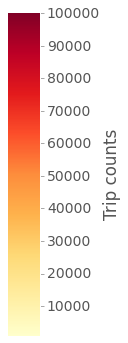

In [135]:
# Make a color scale bar
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize = (.5, 30))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(start_station['trip count'].min(), start_station['trip count'].max())

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap = cmap, norm = norm, orientation = 'vertical')
cb1.set_label('Trip counts')

# Save as file
from pylab import *
savefig('color_scale_start_station.png', bbox_inches = 'tight')

In [136]:
start_station['trip count'].max()

100498

In [137]:
start_station['trip count'].min()

843

In [139]:
start_station['mean duration'].max() / 60

64.632755231818706

In [140]:
start_station['mean duration'].min() / 60

9.5864180572513913

<a id='Map_end'></a>
## 3. Map trip count and duration according to end station

Get only start station id, name and coordinates, drop duplicates and add columns with trip counts and mean duration for each station.

In [136]:
end_station = df.iloc[:, [7, 8, 9, 10]]
end_station.index = end_station['end station id']
end_station.head()

,end station id,end station name,end station latitude,end station longitude
end station id,,,,
263,263,Elizabeth St & Hester St,40.717290,-73.996375
259,259,South St & Whitehall St,40.701221,-74.012342
2022,2022,E 59 St & Sutton Pl,40.758491,-73.959206
526,526,E 33 St & 5 Ave,40.747659,-73.984907
436,436,Hancock St & Bedford Ave,40.682166,-73.953990


In [137]:
end_station = end_station.drop_duplicates()
end_station.shape

(345, 4)

In [138]:
# Add trip counts and mean trip duration for each end station
count_end_station = df.groupby('end station id')['end station id'].count()
mean_end_station = df.groupby('end station id')['tripduration'].mean()
end_station['trip count'] = count_end_station
end_station['mean duration'] = mean_end_station
end_station.head()

,end station id,end station name,end station latitude,end station longitude,trip count,mean duration
end station id,,,,,,
263,263,Elizabeth St & Hester St,40.717290,-73.996375,27929,896.037739
259,259,South St & Whitehall St,40.701221,-74.012342,17804,1227.872781
2022,2022,E 59 St & Sutton Pl,40.758491,-73.959206,17141,1171.556910
526,526,E 33 St & 5 Ave,40.747659,-73.984907,26781,727.753594
436,436,Hancock St & Bedford Ave,40.682166,-73.953990,3474,1336.880541


In [120]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

norm = Normalize(end_station['trip count'].min(), end_station['trip count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
end_station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                             tiles = tileset,
                             attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                             zoom_start = 12)

for index, row in end_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    end_station_map.circle_marker(location = [row['end station latitude'],
                                              row['end station longitude']],
                                  popup = row['end station name'],
                                  radius = row['mean duration'] / 10,
                                  fill_color = color, line_color = color)

end_station_map.create_map(path = 'end_station_map.html')

del end_station_map

In [2]:
from IPython.display import IFrame
IFrame('end_station_map.html', width = 400, height = 600)

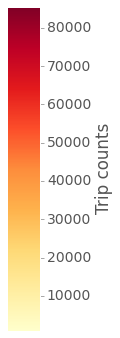

In [139]:
# Make a color scale bar
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize = (.5, 30))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(end_station['trip count'].min(), end_station['trip count'].max())

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap = cmap, norm = norm, orientation = 'vertical')
cb1.set_label('Trip counts')

# Save as file
from pylab import *
savefig('color_scale_end_station.png', bbox_inches = 'tight')

In [144]:
end_station['trip count'].max()

85494

In [145]:
end_station['trip count'].min()

878

In [146]:
end_station['mean duration'].max() / 60

65.375834719911254

In [147]:
end_station['mean duration'].min() / 60

8.3333425714930929

<a id='Gif_start'></a>
## 4. Hourly changes in start station use (video)

* Subset data to include only weekdays
* Calculate station trip counts and mean duration for each hour in the day
* Plot each hour separately and save a screenshot
* Make dynamic visualization video of changes over the 24 hours

The analysis is just like above, including preparing a simple dataframe including only the variables end station id, name and coordinates, and then dropping duplicates and adding variables with trip counts and mean duration for each station. The difference is that this is done on subsets including only weekdays and then further broken down by hour of the day.

In [34]:
# Index by 'datetime64' data in 'starttime' variable and get subset of weekdays
df.index = df['starttime']
weekdays = df[df.index.weekday < 5]

# There are some stations with relatively low trip counts and trip duration outliers
# This inflates marker size to artificially big sizes
# Simply removing trips with duration > 5 hours (18'000 seconds) takes care of this
weekdays = weekdays.loc[weekdays.tripduration < 18000,:]

In [35]:
start_station = weekdays.iloc[:,[3, 4, 5, 6]]
start_station.index = start_station['start station id']
start_station = start_station.drop_duplicates()
start_station.shape

(345, 4)

In [36]:
# Loop through hourly subsets of the 'weekdays' dataFrame
# Calculate trip counts and mean duration for each station
# Add results to complete dataFrame and move on to next iteration
print('Calculating trip attributes for hourly subset:')
whole_day = pd.DataFrame()
for hour in range(24):
    print('... ' + str(hour) + ' hrs')
    subset = weekdays.loc[weekdays.starttime.dt.hour == hour,:]
    
    trip_count = subset.groupby('start station id')['start station id'].count()
    mean_duration = subset.groupby('start station id')['tripduration'].mean()
    
    start_station['trip count'] = trip_count
    start_station['mean duration'] = mean_duration
    start_station['hour'] = hour # Collect hour for easy subsetting below
    
    whole_day = pd.concat([whole_day, start_station], axis=0)

Calculating trip attributes for hourly subset:
... 0 hrs
... 1 hrs
... 2 hrs
... 3 hrs
... 4 hrs
... 5 hrs
... 6 hrs
... 7 hrs
... 8 hrs
... 9 hrs
... 10 hrs
... 11 hrs
... 12 hrs
... 13 hrs
... 14 hrs
... 15 hrs
... 16 hrs
... 17 hrs
... 18 hrs
... 19 hrs
... 20 hrs
... 21 hrs
... 22 hrs
... 23 hrs


The next step is generating the html files of the maps. The color scale representing trip counts will be defined from the complete dataset, including trip counts for every station for all 24 hours in the day: `whole_day` dataframe generated in the previous cell. This will allow vsualization of differences in citibike use between different hours.

Turns out that using the minimum and maximum values directly puts most station marker colors close to the minimum (light yellow color). This likely means that a few outlier rows (trip counts for a few stations for a certain hours) have much higher trip counts than most other station-hour units. We can test this by looking at ranks of trip counts.

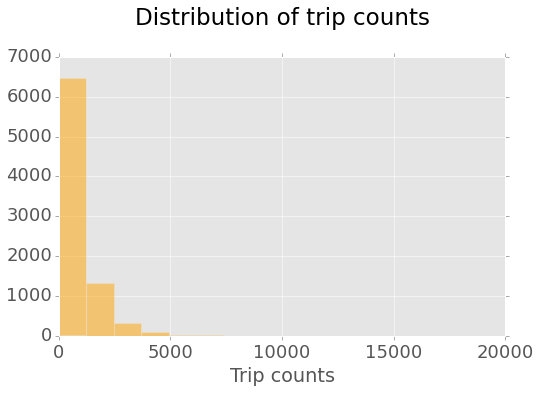

In [103]:
plt.rcParams.update({'font.size': 16})
whole_day['trip count'].hist(figsize = (8,5), bins = 15, alpha = 0.5, color = 'orange')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax = plt.gca()
#ax.set_axis_bgcolor('white')
plt.title('Distribution of trip counts\n')
plt.xlabel('Trip counts')
plt.ylabel('')

In [37]:
whole_day['trip count'].max()

18459.0

In [38]:
trip_count_rank = whole_day.sort(columns = 'trip count', ascending = False)
trip_count_rank.head(20)

,start station id,start station name,start station latitude,start station longitude,trip count,mean duration,hour
start station id,,,,,,,
521,521,8 Ave & W 31 St,40.750450,-73.994811,18459,778.223143,8
521,521,8 Ave & W 31 St,40.750450,-73.994811,17070,799.472408,7
519,519,E 42 St & Vanderbilt Ave,40.752416,-73.978370,12266,748.583727,17
519,519,Pershing Square North,40.751873,-73.977706,12266,748.583727,17
519,519,Pershing Square N,40.751884,-73.977702,12266,748.583727,17
519,519,E 42 St & Vanderbilt Ave,40.752416,-73.978370,11303,786.713262,18
519,519,Pershing Square North,40.751873,-73.977706,11303,786.713262,18
519,519,Pershing Square N,40.751884,-73.977702,11303,786.713262,18
521,521,8 Ave & W 31 St,40.750450,-73.994811,10960,725.375730,9


Even though the maximum trip count is **18'459**, the histogram clearly shows that such high trip counts are extremely rare. The ranked dataframe printed above shows those rare cases in which trip counts are so high. In fact, going back to the histogram we can see that the frequency of trip counts only gets any relevant at counts below **5'000**. A way to fix the visualization problem would be to simply use the logarithm of the counts. This would allow for a smoother distribution of the colors and an effective visualization. However, in this particular case, these outliers being so rare, I will rather use the value of 5'000 to define the maximum for the color scale to use in the map. This will also achieve a smoother color distribution.

In [106]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

# Create a folium map html file for each hour
print('Building map for hourly subset:')
norm = Normalize(whole_day['trip count'].min(), 5000)

for hour in range(24):
    print('... ' + str(hour) + ' hrs')
    whole_day_sub = whole_day.loc[whole_day['hour'] == hour, ]
    
    # Get dark tileset from CartBD (https://cartodb.com/basemaps)
    tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
    start_station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                                  tiles = tileset,
                                  attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                                  zoom_start = 12)
    
    for index, row in whole_day_sub.iterrows():
        color = rgb2hex(cm.YlOrRd(norm(row['trip count'])))
        start_station_map.circle_marker(location = [row['start station latitude'],
                                                    row['start station longitude']],
                                        popup = row['start station name'],
                                        radius = row['mean duration'] / 8,
                                        fill_color = color, line_color = color)
        
    start_station_map.create_map(path = str(hour) + '_start_station_map.html')

Building map for hourly subset:
... 0 hrs
... 1 hrs
... 2 hrs
... 3 hrs
... 4 hrs
... 5 hrs
... 6 hrs
... 7 hrs
... 8 hrs
... 9 hrs
... 10 hrs
... 11 hrs
... 12 hrs
... 13 hrs
... 14 hrs
... 15 hrs
... 16 hrs
... 17 hrs
... 18 hrs
... 19 hrs
... 20 hrs
... 21 hrs
... 22 hrs
... 23 hrs


In [50]:
whole_day['mean duration'].min() / 60

2.0666666666666669

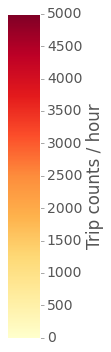

In [39]:
# Make a color scale bar
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize = (.5, 30))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(whole_day['trip count'].min(), 5000)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap = cmap, norm = norm, orientation = 'vertical')
cb1.set_label('Trip counts / hour')

# Save as file
from pylab import *
savefig('color_scale_start_station_hourly.png', bbox_inches = 'tight')

Now that I have the html maps for each hour, I can make a video of the transitions, as a rather low tech, non-interactive, dynamic visualization of the changes in citibike station use in differents times of weekdays. A simple way to do it is to save screenshots of the maps and use those to make a movie using Apple's iMovie.